![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    MeteoScreening from database (influxdb)
</b>
</span>

---
**Notebook version**: `7.2` (8 Sep 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)

</br>

# **ABOUT THIS NOTEBOOK**

In this notebook, the raw data are downloaded from the database, quality-screened, resampled and then uploaded to the database using the [StepwiseMeteoScreeningDb](https://gitlab.ethz.ch/diive/diive/-/blob/main/diive/pkgs/qaqc/meteoscreening.py) class in [diive](https://gitlab.ethz.ch/diive/diive).  

**Here is an overview of what is done in this notebook**:
- (1) **USER SETTINGS**: First, we specify some general settings for the site and variable
- (2) **AUTO-SETTINGS**: With this info, some settings are set automatically
- (3) **DOWNLOAD DATA FROM DATABASE WITH `dbc-influxdb`**: Then original raw data are downloaded from the database. This step uses the Python module  
`dbc-influxdb` to download the data.
- (4) **METEOSCREENING WITH `diive`**: The downloaded data is then quality-screened using the Python library `diive`. The screening is done on the *high-resolution* data,  
i.e., in the original time resolution of the raw data. After the screening, data are resampled to 30MIN time resolution, the same resolution that we typically use for the fluxes.
- (5) **UPLOAD DATA TO THE DATABASE WITH `dbc-influxdb`**: The screened and resampled data are then uploaded to the database.

</br>

</br>

# **USER SETTINGS** (please adjust)

## Site

In [1]:
SITE = 'ch-fru'
SITE_LAT = 47.115833   # CH-FRU
SITE_LON = 8.537778  # CH-FRU

## Variables to screen
- Specify variables as shown in the database
- `FIELDS`: Variables are called FIELDS in the database. InfluxDB stores variable names as '_field'. You can specify multiple fields, given as a list e.g. `['TA_NABEL_T1_35_1', 'TA_T1_20_1]`
- `MEASUREMENTS`: Only **one** measurement allowed. Measurement name that is used to group similar variables together, e.g., `TA` contains all air temperature variables, `SW` are all short-wave radiation measurements and `SWC` all soil water measurements. 

In [2]:
FIELDS = [
    # 'TS_GF1_0.01_1',
    # 'TS_GF1_0.04_1',
    # 'TS_GF1_0.05_2',
    # 'TS_GF1_0.07_1',
    'TS_GF1_0.15_1',
    # 'TS_GF1_0.1_1',
    # 'TS_GF1_0.1_2',
    # 'TS_GF1_0.25_1',
    # 'TS_GF1_0.2_2',
    # 'TS_GF1_0.3_2',
    # 'TS_GF1_0.4_1',
    # 'TS_GF1_0.4_2',
    # 'TS_GF1_0.5_2',
    # 'TS_GF1_0.75_2',
    # 'TS_GF1_1_2',
]
MEASUREMENT = 'TS'

## Time range to screen
- `START`: Screen data starting with this date (the start date itself **IS** included)
- `STOP`: Screen data before this date (the stop date itself **IS NOT** included)

In [3]:
START = '2021-01-01 00:00:01'
STOP = '2025-01-01 00:00:01'

## Resampling aggregation
- The resampling of the high-res data to 30MIN time resolution will be done using this aggregation method; two options: `mean` or `sum`

<div class="alert alert-block alert-info">
    For <b>precipitation</b> make sure to use `sum` because we need the 30MIN sums.
    
</div>

In [4]:
RESAMPLING_AGG = 'mean'
# RESAMPLING_AGG = 'sum'

</br>

# **AUTO-SETTINGS**

## Data settings

<div class="alert alert-block alert-success">
    <b>New in v7</b> <i>timezone_offset_to_utc_hours</i> is now given as integer, <i>delete_from_db_before_upload</i> deleted time range for variable from database before the new data are uploaded. 
</div>

In [5]:
DATA_VERSION = 'raw'
TIMEZONE_OFFSET_TO_UTC_HOURS = 1  # Timezone, e.g. "1" is translated to timezone "UTC+01:00" (CET, winter time)
RESAMPLING_FREQ = '30min'  # During MeteoScreening the screened high-res data will be resampled to this frequency; '30min' = 30-minute time resolution
# DIRCONF = r'P:\Flux\RDS_calculations\_scripts\_configs\configs'  # Location of configuration files, needed e.g. for connection to database
DIRCONF = r'F:\Sync\luhk_work\20 - CODING\22 - POET\configs'

## Imports

In [6]:
import importlib.metadata
import warnings
from datetime import datetime

# %matplotlib inline
import pandas as pd
# from bokeh.plotting import output_notebook, show
# output_notebook()
from dbc_influxdb import dbcInflux  # Needed for communicating with the database

from diive.core.plotting.timeseries import TimeSeries
from diive.core.times.times import DetectFrequency
from diive.pkgs.qaqc.meteoscreening import StepwiseMeteoScreeningDb

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 1000)
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"This page was last modified on: {dt_string}")
version_dbc = importlib.metadata.version("dbc_influxdb")
print(f"dbc-influxdb version: v{version_dbc}")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

This page was last modified on: 2025-04-20 23:22:32
dbc-influxdb version: v0.13.1
diive version: v0.87.0


## Automatic settings (do not adjust):

<div class="alert alert-block alert-success">
    <b>New in v7</b> <i>BUCKET_PROCESSED</i> has a new name, buckets for processed data now use the suffix `_processed`.
</div>

In [7]:
BUCKET_RAW = f'{SITE}_raw'  # The 'bucket' where data are stored in the database, e.g., 'ch-lae_raw' contains all raw data for CH-LAE
BUCKET_PROCESSED = f'{SITE}_processed'  # The 'bucket' where data are stored in the database, e.g., 'ch-lae_processed' contains all processed data for CH-LAE
# BUCKET_PROCESSED= f'a'  # Bucket for testing
print(f"Bucket containing raw data (source bucket): {BUCKET_RAW}")
print(f"Bucket containing processed data (destination bucket): {BUCKET_PROCESSED}")

Bucket containing raw data (source bucket): ch-fru_raw
Bucket containing processed data (destination bucket): ch-fru_processed


## Connect to database

In [8]:
dbc = dbcInflux(dirconf=DIRCONF)

Reading configuration files was successful.
Connection to database works.


## Check available variables
- Since we are now connected to the database, we can make a quick check if the variable(s) we want to screen are really in the database.  
Below you can show show all available fields in the selected measurement.
- However, if the desired variable(s) are indeed listed here, it does not necessarily mean that they are also available during the  
selected **time period**. This can be the case if the variable(s) for that time period were not uploaded to the database.

In [9]:
# display(dbc.show_fields_in_measurement(bucket=BUCKET_RAW, measurement=MEASUREMENT))

</br>

</br>

# **DOWNLOAD DATA FROM DATABASE WITH `dbc-influxdb`**
- Here the Python library `dbc-influxdb` is used to download data from the database.
- The name of the library means **d**ata**b**ase **c**ommunication using **influxdb**.
- You can find the source code of `dbc-influxdb` [here](https://gitlab.ethz.ch/poet/dbc-influxdb).
- There is no need to adjust the settings here, the variables given earlier (above) are directly used.
- At this point we have already established the connection to the database and stored the connection details in the variable `dbc`.
- Now we can use the method `dbc.download()` to start the data download.

## Download data

In [10]:
%%time
data_simple, data_detailed, assigned_measurements = dbc.download(
    bucket=BUCKET_RAW,
    measurements=[MEASUREMENT],
    fields=FIELDS,
    start=START,
    stop=STOP,
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version=DATA_VERSION
)


DOWNLOADING
    from bucket ch-fru_raw
    variables ['TS_GF1_0.15_1']
    from measurements ['TS']
    from data version ['raw']
    between 2021-01-01 00:00:01 and 2025-01-01 00:00:01
    with timezone offset to UTC of 1
Using querystring:
from(bucket: "ch-fru_raw") |> range(start: 2021-01-01T00:00:01+01:00, stop: 2025-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "TS") |> filter(fn: (r) => r["data_version"] == "raw") |> filter(fn: (r) => r["_field"] == "TS_GF1_0.15_1") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
Used querystring: from(bucket: "ch-fru_raw") |> range(start: 2021-01-01T00:00:01+01:00, stop: 2025-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "TS") |> filter(fn: (r) => r["data_version"] == "raw") |> filter(fn: (r) => r["_field"] == "TS_GF1_0.15_1") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
querystring was constructed from:
    bucketstring: from(bucket: "ch-fru_raw")
    rang

## Check downloaded data
### `dbc` downloads three variables:
- `data_simple`: This is the simplest data download. It contains only the high-resolution variable(s) from the specified measurement. Each variable is in a separate column. Since different variables, can have different time resolutions, the highest time resolution across the variables is used as the index. This means that lower resolution variables will show gaps in the higher resolution timestamp.
- `data_detailed`: This is the most important variable for the MeteoScreening from the database, because it contains not only the high-resolution time series of the variable(s), but also their tags. The tags are important when uploading data to the database. This is a very special format, because data for each variable are stored in a dictionary. A dictionary is a data structure that stores key-value pairs. The key is the variable name (e.g., `TA_NABEL_T1_35_1`) and the value is a complete dataframe that contains the time series of the respective variable and all tags.
- `assigned_measurements`: An auxiliary variable that is useful to check whether the measurement of the variable(s) is correct. In case we are screening air temperatures, the measurement must be `TA`.

#### `data_simple`
- Simply contains the time series of the measured variable(s) in a nice-to-look-at dataframe.

In [11]:
data_simple

,TS_GF1_0.15_1
TIMESTAMP_END,
2021-01-01 00:01:00,1.750031
2021-01-01 00:02:00,1.754791
2021-01-01 00:03:00,1.751617
2021-01-01 00:04:00,1.748444
2021-01-01 00:05:00,1.750031
...,...
2024-12-31 23:56:00,2.279042
2024-12-31 23:57:00,2.274292
2024-12-31 23:58:00,2.277461


#### `data_detailed`
- Dictionary of key-value pairs: the variable name is the key, the respective data (measured time series and tags) are the values

In [12]:
data_detailed

{'TS_GF1_0.15_1':                                                config_filetype data_raw_freq data_version filegroup freq gain hpos offset raw_units        raw_varname repl    site units        varname  vpos  TS_GF1_0.15_1
 TIMESTAMP_END                                                                                                                                                                                                
 2021-01-01 00:01:00  FRU10-RAW-TBL1-201811051615-TOA5-DAT-1MIN           min          raw  10_meteo  min  1.0  GF1    0.0      degC  TS_GF1_0x15_1_Avg    1  CH-FRU  degC  TS_GF1_0.15_1  0.15       1.750031
 2021-01-01 00:02:00  FRU10-RAW-TBL1-201811051615-TOA5-DAT-1MIN           min          raw  10_meteo  min  1.0  GF1    0.0      degC  TS_GF1_0x15_1_Avg    1  CH-FRU  degC  TS_GF1_0.15_1  0.15       1.754791
 2021-01-01 00:03:00  FRU10-RAW-TBL1-201811051615-TOA5-DAT-1MIN           min          raw  10_meteo  min  1.0  GF1    0.0      degC  TS_GF1_0x15_1_Avg    

<br>
Since the output above is not so nice to look at, we loop through the dictionary and display the first and last records for each variable:

In [13]:
for varname, frame in data_detailed.items():
    print(f"{'-' * 40}\nData for {varname}:")
    display(frame)

----------------------------------------
Data for TS_GF1_0.15_1:


,config_filetype,data_raw_freq,data_version,filegroup,freq,gain,hpos,offset,raw_units,raw_varname,repl,site,units,varname,vpos,TS_GF1_0.15_1
TIMESTAMP_END,,,,,,,,,,,,,,,,
2021-01-01 00:01:00,FRU10-RAW-TBL1-201811051615-TOA5-DAT-1MIN,min,raw,10_meteo,min,1.0,GF1,0.0,degC,TS_GF1_0x15_1_Avg,1,CH-FRU,degC,TS_GF1_0.15_1,0.15,1.750031
2021-01-01 00:02:00,FRU10-RAW-TBL1-201811051615-TOA5-DAT-1MIN,min,raw,10_meteo,min,1.0,GF1,0.0,degC,TS_GF1_0x15_1_Avg,1,CH-FRU,degC,TS_GF1_0.15_1,0.15,1.754791
2021-01-01 00:03:00,FRU10-RAW-TBL1-201811051615-TOA5-DAT-1MIN,min,raw,10_meteo,min,1.0,GF1,0.0,degC,TS_GF1_0x15_1_Avg,1,CH-FRU,degC,TS_GF1_0.15_1,0.15,1.751617
2021-01-01 00:04:00,FRU10-RAW-TBL1-201811051615-TOA5-DAT-1MIN,min,raw,10_meteo,min,1.0,GF1,0.0,degC,TS_GF1_0x15_1_Avg,1,CH-FRU,degC,TS_GF1_0.15_1,0.15,1.748444
2021-01-01 00:05:00,FRU10-RAW-TBL1-201811051615-TOA5-DAT-1MIN,min,raw,10_meteo,min,1.0,GF1,0.0,degC,TS_GF1_0x15_1_Avg,1,CH-FRU,degC,TS_GF1_0.15_1,0.15,1.750031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 23:56:00,FRU10-RAW-TBL1-201811051615-TOA5-DAT-1MIN,min,raw,10_meteo,min,1.0,GF1,0.0,degC,TS_GF1_0x15_1_Avg,1,CH-FRU,degC,TS_GF1_0.15_1,0.15,2.279042
2024-12-31 23:57:00,FRU10-RAW-TBL1-201811051615-TOA5-DAT-1MIN,min,raw,10_meteo,min,1.0,GF1,0.0,degC,TS_GF1_0x15_1_Avg,1,CH-FRU,degC,TS_GF1_0.15_1,0.15,2.274292
2024-12-31 23:58:00,FRU10-RAW-TBL1-201811051615-TOA5-DAT-1MIN,min,raw,10_meteo,min,1.0,GF1,0.0,degC,TS_GF1_0x15_1_Avg,1,CH-FRU,degC,TS_GF1_0.15_1,0.15,2.277461


#### `assigned_measurements`
- Contains the *automatically* detected measurement for the selected variables, useful as check to make sure the variable was properly identified.

In [14]:
assigned_measurements

{'TS_GF1_0.15_1': 'TS'}

<br>
It is possible that a variable that we want to screen is not available in the database (oh no). To find out which variable that might be we have this piece of code:

In [15]:
print(f"Data available for: {data_detailed.keys()}\n")
vars_not_available = [v for v in FIELDS if v not in data_detailed.keys()]
print(f"No data available for the following variables: {vars_not_available}")

Data available for: dict_keys(['TS_GF1_0.15_1'])

No data available for the following variables: []


In [16]:
# Remove variables that are not available during this time period from FIELDS. 
for rem in vars_not_available:
    print(rem)
    FIELDS.remove(rem)
    print(f"Removed variables {rem} from FIELDS because it is not available during this time period.")

## Save downloaded high-res raw data to file (optional)
- If you really want, you can download the full resolution data to a file. This can be useful if you want to do the screening elsewhere.

In [17]:
# data_detailed['TA_NABEL_T1_35_1'].to_csv("mylovelyhorse.csv")

## Plot downloaded high-res data
- Yes, this is indeed a plot of the downloaded full-resolution data.
- Because we have plenty of time and space, each variable gets it's own plot.
- If there is only one variable, then there is only one plot.

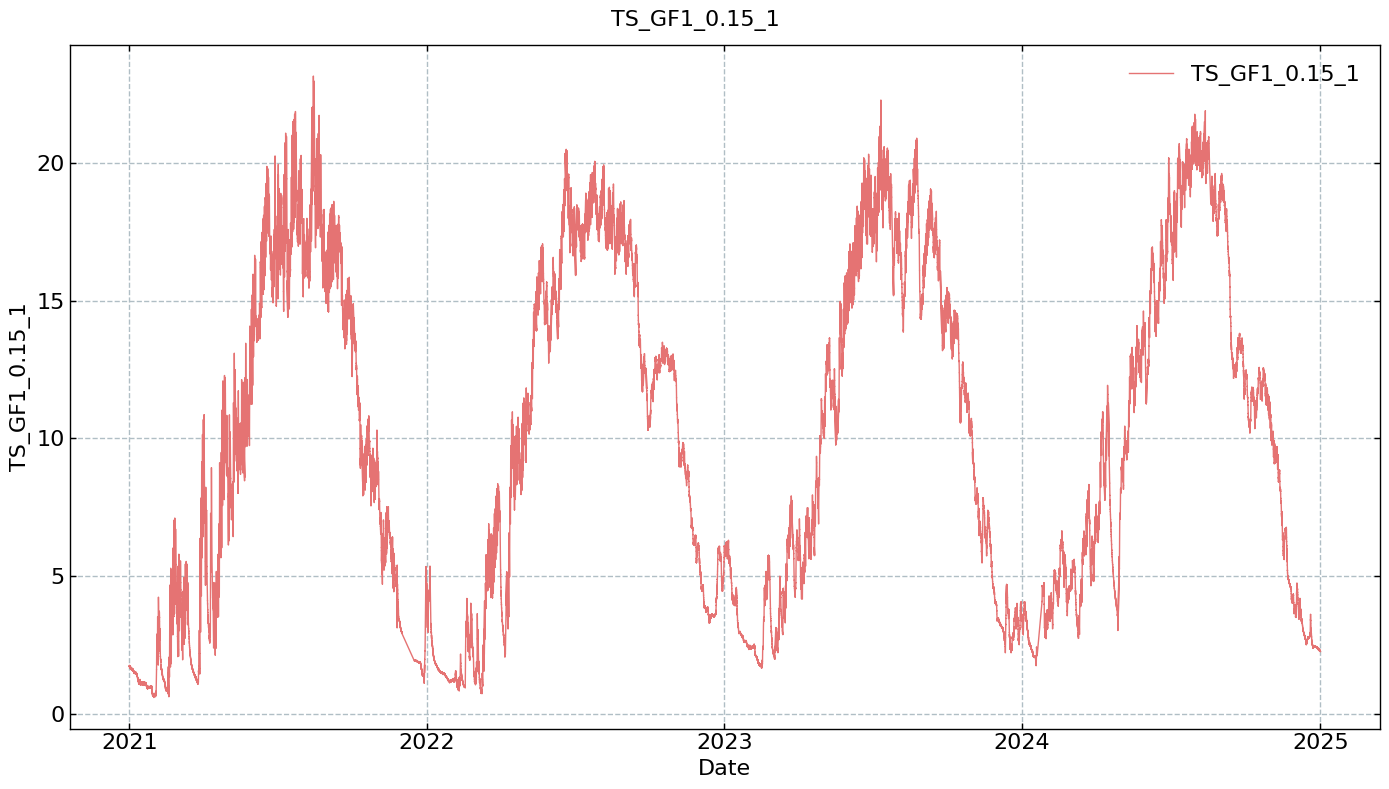

In [18]:
for varname, frame in data_detailed.items():
    # TimeSeries(series=frame[varname]).plot_interactive()
    TimeSeries(series=frame[varname]).plot()

</br>

# **Start MeteoScreening with `diive`**

In [19]:
mscr = StepwiseMeteoScreeningDb(site=SITE,
                                data_detailed=data_detailed,
                                # measurement=MEASUREMENT,
                                fields=FIELDS,
                                site_lat=SITE_LAT,
                                site_lon=SITE_LON,
                                utc_offset=TIMEZONE_OFFSET_TO_UTC_HOURS)

Validating data for variable TS_GF1_0.15_1 ... 
Found 2 unique frequencies across 2066963 records.
Found frequencies:
    Found time resolution 60.0 (seconds) with 2066959 records (100.00% of total records). 
    Found time resolution 180.0 (seconds) with 4 records (0.00% of total records).   -->  Frequency will be ignored, too few records.
The following frequencies will be used: [60.0] (seconds)


<br>
Now let's take a look at the data that will be screened:

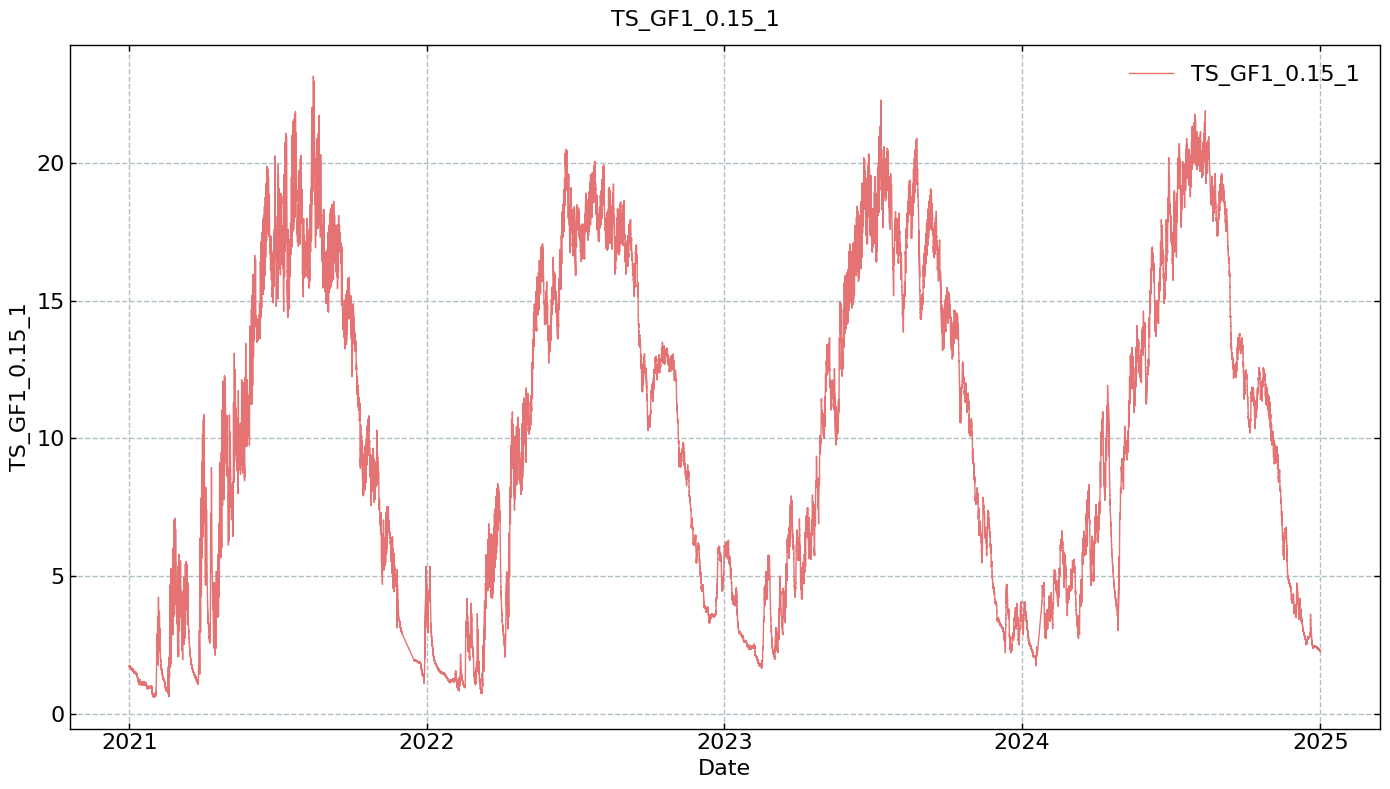

In [20]:
# mscr.showplot_orig(interactive=True)
mscr.showplot_orig()

</br>

</br>

# **OUTLIER DETECTION**: generate quality flags on high-resolution data (if needed)
- After running a specific test, one or more preview plots are generated
- The respective quality flag is not added immediately to the data, but only after `mscr.addflag()` is executed
- This allows to generate multiple previews to see how the filter works
- When `mscr.addflag()` is executed, the quality flag of the most recent quality test is added to the data
- At the end of the outlier detection, an overall flag `QCF` is generated

<div class="alert alert-block alert-info">
    <b>Tip:</b> If the plots look good and you think the data do not require any screening, you can skip this section and jump directly to Corrections or Resampling. 
</div>

</br>

## Start outlier detection

In [ ]:
mscr.start_outlier_detection()

</br>

## Plot current outlier-cleaned data
- During <i>outlier detection</i>, you can jump back here to plot the current version of <b>cleaned</b> data.

In [ ]:
for key, val in mscr.outlier_detection.items():
    # val.showplot_cleaned(interactive=True)
    val.showplot_cleaned(interactive=False)
    # mscr.outlier_detection['TA_T1_2_1'].showplot_cleaned()
# mscr.showplot_cleaned(interactive=True)
# mscr.showplot_cleaned(interactive=False)

</br>

</br>

## Flag, outlier detection: **Manual removal**
*Generate flag for data points that should be removed*

To find erroneous time periods, use this interactive plot to identify the exact timestamps or time ranges:

In [ ]:
# Example removal of dates
REMOVE_DATES = [
    ['2024-07-14 07:15:00', '2024-07-19 00:00:15'],  # Remove time range
    # '2022-08-23 11:45:00',  # Remove data point
    # '2022-01-12 13:15:00',  # Remove data point
    # ['2022-08-15', '2022-08-16']  # Remove time range
]
mscr.flag_manualremoval_test(remove_dates=REMOVE_DATES, showplot=True, verbose=True)

In [ ]:
mscr.addflag()

</br>

</br>

## Flag, outlier detection: **Hampel filter** across all data
*Identify outliers in a sliding window based on the Hampel filter*

<div class="alert alert-block alert-success">
    <b>New in v7</b>
</div>

In [ ]:
WINDOW_LENGTH = 1000
N_SIGMA = 4.5
mscr.flag_outliers_hampel_test(window_length=WINDOW_LENGTH, n_sigma=N_SIGMA, showplot=True, verbose=True, repeat=False)

In [ ]:
mscr.addflag()

</br>

</br>

## Flag, outlier detection: **Hampel filter** separate for daytime and nighttime
*Identify outliers in a sliding window based on the Hampel filter, separately for daytime and nighttime data.*

<div class="alert alert-block alert-success">
    <b>New in v7</b>
</div>

In [ ]:
WINDOW_LENGTH = 1000
N_SIGMA_DT = 4.5
N_SIGMA_NT = 4.5
mscr.flag_outliers_hampel_dtnt_test(window_length=WINDOW_LENGTH, n_sigma_dt=N_SIGMA_DT, n_sigma_nt=N_SIGMA_NT, showplot=True, verbose=True, repeat=False)

In [ ]:
mscr.addflag()

</br>

</br>

## Flag, outlier detection: **z-score over all data** separate for daytime and nighttime
*Identify outliers based on the z-score, separately for daytime and nighttime*

<div class="alert alert-block alert-warning">
    <b>Warning for radiation:</b> This test easily removes nighttime values that are below zero. However, below-zero radiation data are corrected in a later step (Corrections). Make sure that no radiation data below zero are removed when using this test.
</div>

<div class="alert alert-block alert-warning">
    <b>Warning for relative humidity:</b> This test easily removes values that are above 100% relative humidity. However, values > 100% are corrected in a later step (Corrections). Make sure that no RH data above 100% are removed when using this test.
</div>

In [ ]:
THRESHOLD = 4.5
mscr.flag_outliers_zscore_dtnt_test(thres_zscore=THRESHOLD, showplot=True, verbose=True, repeat=True)

In [ ]:
mscr.addflag()

</br>

## Flag, outlier detection: **rolling z-score over all data**
*Identify outliers based on the rolling z-score*

<div class="alert alert-block alert-success">
    <b>New in v7</b>
</div>

In [ ]:
THRESHOLD = 4.5
WINSIZE = 1440 * 7
mscr.flag_outliers_zscore_rolling_test(thres_zscore=THRESHOLD, winsize=WINSIZE, showplot=True, verbose=True, repeat=True)

In [ ]:
mscr.addflag()

</br>

## Flag, oulier detection: **Local standard deviation**
*Identify outliers based on the local standard deviation, based on the rolling mean and standard deviation*  
<br>
Parameters:
- `N_SD` ... Number of standard deviations for outliers
- `WINSIZE` ... Number of records used for the rolling time window. If `None` the window size is calculated as 1/20 of data length.

In [ ]:
N_SD = 5.5
WINSIZE = 1440 * 7
mscr.flag_outliers_localsd_test(n_sd=N_SD, winsize=WINSIZE, constant_sd=False, showplot=True, verbose=True, repeat=False)

In [ ]:
mscr.addflag()

</br>

## Outlier flag: **Local standard deviation**, with rolling median and *constant* standard deviation
- keep standard deviation constant by setting parameter `constant_sd=True`

In [ ]:
N_SD = 5.5
WINSIZE = 1440 * 7
mscr.flag_outliers_localsd_test(n_sd=N_SD, winsize=WINSIZE, constant_sd=True, showplot=True, verbose=True, repeat=False)

In [ ]:
mscr.addflag()

</br>

## Flag, outlier detection: **Increments z-score**
*Identify outliers based on the z-score of record increments*

In [ ]:
THRESHOLD = 40
mscr.flag_outliers_increments_zcore_test(thres_zscore=THRESHOLD, showplot=True, verbose=True, repeat=True)

In [ ]:
mscr.addflag()

</br>

</br>

</br>

## Flag, outlier detection: **z-score over all data**
*Identify outliers based on the z-score of records*  
This is a general purpose test that can already solve many outlier issues.

In [ ]:
THRESHOLD = 5.5
mscr.flag_outliers_zscore_test(thres_zscore=THRESHOLD, showplot=True, verbose=True, repeat=True)

In [ ]:
mscr.addflag()

</br>

</br>

</br>

## Flag, outlier detection: **Local outlier factor, daytime/nighttime**
*Identify outliers based on the local outlier factor, done separately for daytime and nighttime data*  
You can find [more info about the general approach here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html).

<div class="alert alert-block alert-danger">
    <b>Do not use this test on high-resolution data (1S, 10S, 1MIN):</b> Computation takes a veeeeery loooong time and is slooooow. But otherwise it works nicely with half-hourly data.
</div>

In [ ]:
# mscr.flag_outliers_lof_dtnt_test(n_neighbors=3, contamination=0.00001, showplot=True, verbose=True, repeat=False, n_jobs=-1)

In [ ]:
# mscr.addflag()

</br>

</br>

## Flag, outlier detection: **Local outlier factor**
*Identify outliers based on the local outlier factor*  
You can find [more info about the general approach here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html).

<div class="alert alert-block alert-danger">
    <b>Do not use this test on high-resolution data (1S, 10S, 1MIN):</b> Computation takes a veeeeery loooong time and is slooooow. But otherwise it works nicely with half-hourly data.
</div>

In [ ]:
# mscr.flag_outliers_lof_test(n_neighbors=30, contamination=0.01, showplot=True, verbose=True, repeat=False, n_jobs=-1)

In [ ]:
# mscr.addflag()

</br>

</br>

## Flag, outlier detection: **Absolute limits**
*Generate flag that indicates if values in data are outside the specified range*

In [ ]:
MIN = -20
MAX = 20
mscr.flag_outliers_abslim_test(minval=MIN, maxval=MAX, showplot=True)

In [ ]:
mscr.addflag()

</br>

</br>

## Flag, outlier detection: **Absolute limits, separate for daytime and nighttime data**
*Identify outliers based on absolute limits separately for daytime and nighttime*

In [ ]:
DT_MINMAX = [-20, 20]
NT_MINMAX = [-5, 5]
mscr.flag_outliers_abslim_dtnt_test(daytime_minmax=DT_MINMAX, nighttime_minmax=NT_MINMAX, showplot=True)

In [ ]:
mscr.addflag()

</br>

</br>

## Flag, outlier detection: **Trim low**
*Flag values below a given absolute limit as outliers, then flag an equal number of datapoints at the high end as outliers.*

<div class="alert alert-block alert-success">
    <b>New in v7</b>
</div>

In [ ]:
TRIM_DAYTIME = False
TRIM_NIGHTTIME = True
LOWER_LIMIT = 10
mscr.flag_outliers_trim_low_test(trim_daytime=TRIM_DAYTIME, trim_nighttime=TRIM_NIGHTTIME, lower_limit=LOWER_LIMIT, showplot=True, verbose=True)

In [ ]:
mscr.addflag()

</br>

</br>

## Flag, outlier detection: **Missing values test**
*Generate flag that indicates missing records in data*
- This test is not really part of the outlier detection tests, but a separate test.
- In this notebook, we can simply add a missing values flag to the existing data.

In [ ]:
mscr.flag_missingvals_test(verbose=True)

</br>

</br>

## **QCF**: calculate overall quality-control flag for high-resolution data  
- The next step (Corrections) needs quality-controlled data, therefore an overall flag `QCF` is created here.

In [ ]:
mscr.finalize_outlier_detection()

### Reports

In [ ]:
mscr.report_outlier_detection_qcf_evolution()

In [ ]:
mscr.report_outlier_detection_qcf_flags()

In [ ]:
mscr.report_outlier_detection_qcf_series()

### Plots

In [ ]:
mscr.showplot_outlier_detection_qcf_heatmaps()

In [ ]:
# mscr.showplot_outlier_detection_qcf_timeseries()

</br>

</br>

# **CORRECTIONS**: done on high-resolution data (if needed)

Currently only needed for SW, PPFD, RH.

</br>

</br>

## Show cleaned data after QCF

In [ ]:
mscr.showplot_cleaned()

</br>

</br>

## Correction: **Remove radiation zero offset**
*Remove nighttime offset from all radiation data and set nighttime to zero*

<div class="alert alert-block alert-info">
    Can be used for <b>SW_IN, SW_OUT, PPFD_IN, PPFD_OUT.</b>
</div>

In [ ]:
mscr.correction_remove_radiation_zero_offset()

</br>

</br>

## Correction: **Remove relative humidity offset**
*Remove relative humidity offset, works for relative humidity data where maximum values should not exceed 100%*  

<div class="alert alert-block alert-info">
    Can be used for <b>RH.</b>
</div>

In [ ]:
# mscr.correction_remove_relativehumidity_offset()

</br>

</br>

## Correction: **Set to max threshold**
*Set values above threshold to threshold*

In [ ]:
mscr.correction_setto_max_threshold(threshold=30)

</br>

</br>

## Correction: **Set to min threshold**
*Set values below threshold to threshold*

In [ ]:
mscr.correction_setto_min_threshold(threshold=-5)

</br>

</br>

## Correction: **Set to value**
*Set records in time range(s) to value*
- This can be useful e.g. to set precipitation to zero during a time period where the sensor was tested during a field visit

In [ ]:
# mscr.showplot_cleaned(interactive=True)

In [ ]:
DATES = [
    ['2022-04-01', '2022-04-05'],
    ['2022-09-05', '2022-09-07']
]

In [ ]:
mscr.correction_setto_value(dates=DATES, value=3.7, verbose=1)

In [ ]:
mscr.showplot_cleaned(interactive=False)

</br>

</br>

# **ANALYSES** <a class="anchor" id="resampling"></a>

## Check for potential timestamp shifts
*Compare radiation time series to potential radiation*

<div class="alert alert-block alert-info">
    Can be used for <b>SW_IN, SW_OUT, PPFD_IN, PPFD_OUT.</b>
</div>

This analysis generates a plot that shows the radiation time series in comparison to potential radiation.
- The first (top) panel shows daily correlations
- The second panel shows potential radiation and measured radiation on low correlation days all in one plot
- The third panel (with 3 plots) shows potential radiation and measured radiation on the three days when their correlation was the **lowest**
- The fourth (bottom) panel (with 3 plots) shows potential radiation and measured radiation on the three days when their correlation was the **highest**

In [ ]:
_ = mscr.analysis_potential_radiation_correlation(utc_offset=1, mincorr=0.7, showplot=True)

</br>

</br>

# **RESAMPLING** <a class="anchor" id="resampling"></a>

## Resample

In [21]:
RESAMPLING_AGG

'mean'

In [22]:
mscr.resample(to_freqstr=RESAMPLING_FREQ, agg=RESAMPLING_AGG, mincounts_perc=.25)

[resample_series_to_30MIN]  running resample_series_to_30MIN ...
Resampling data from min to 30min frequency ...


## Plot original and resampled data

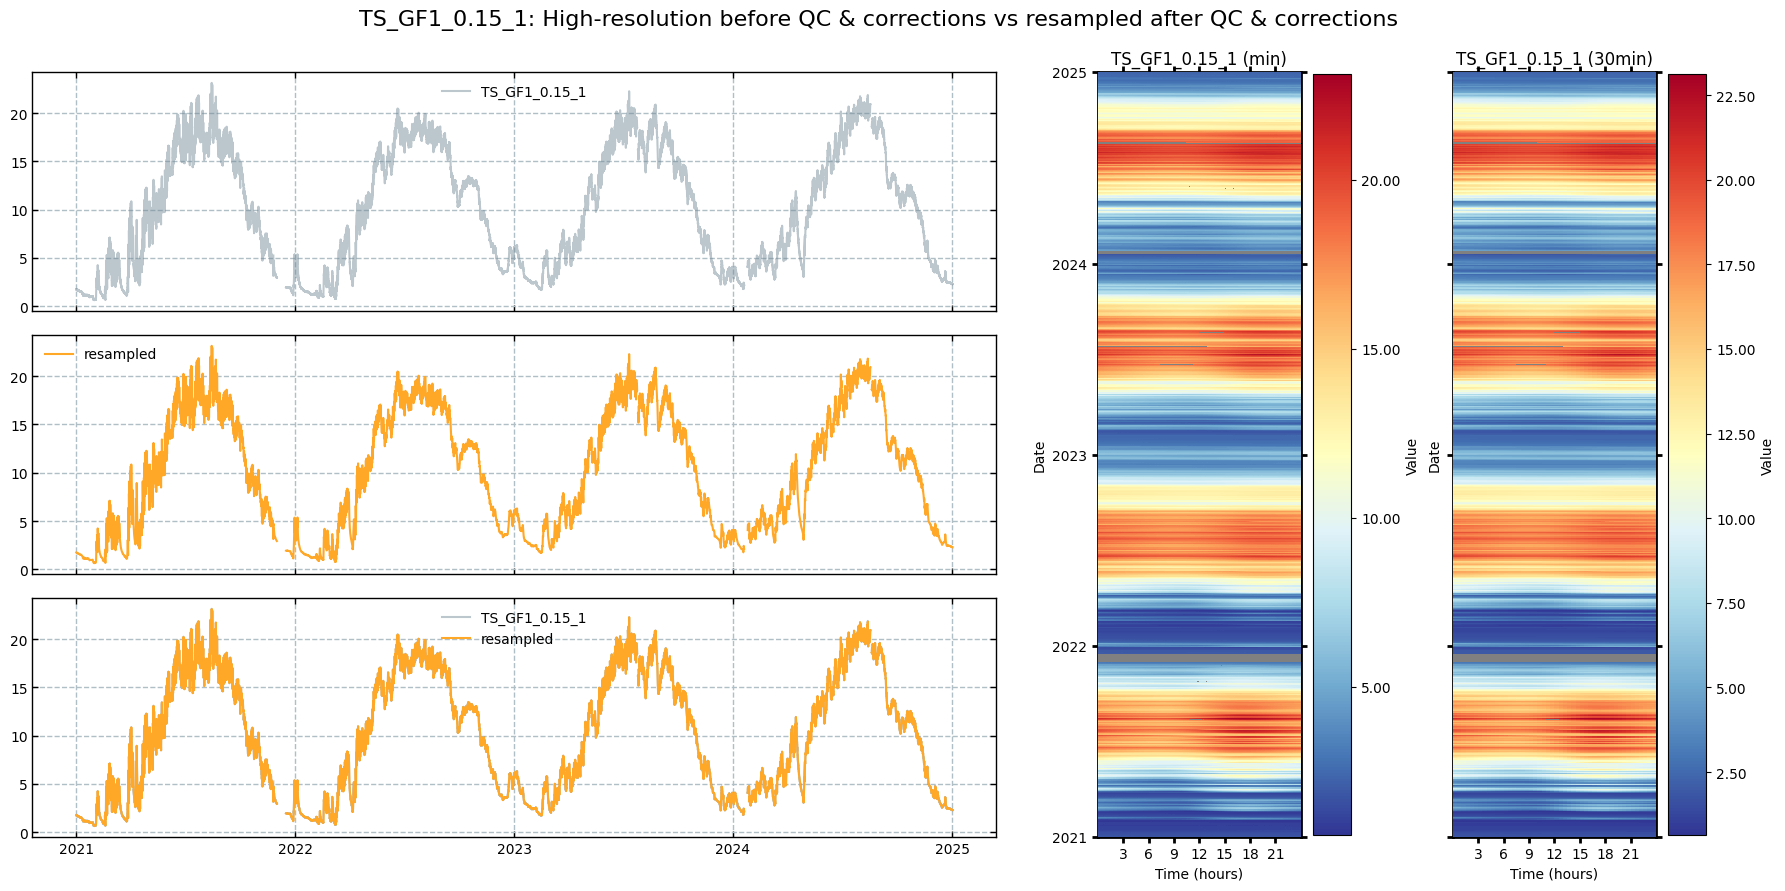

In [23]:
mscr.showplot_resampled()

## Check time resolution of resampled data

In [24]:
for v in mscr.resampled_detailed.keys():
    print(f"{'-' * 20}\n{v}")
    _checkfreq = DetectFrequency(index=mscr.resampled_detailed[v].index, verbose=True).get()
    if _checkfreq == RESAMPLING_FREQ:
        print(f"TEST PASSED - The resampled variable {v} has a time resolution of {_checkfreq}.")
    else:
        print(
            f"{'#' * 20}(!)TEST FAILED - The resampled variable {v} does not have the expected time resolution of {_checkfreq}.{'#' * 20}")

--------------------
TS_GF1_0.15_1
Detecting time resolution from timestamp TIMESTAMP_END ... OK
   Detected 30min time resolution with MAXIMUM confidence.
   All approaches yielded the same result:
       from full data = 30min / full data (OK)
       from timedelta = 30min / 100% occurrence (OK)
       from progressive = 30min / data 1000+1000 (OK)

TEST PASSED - The resampled variable TS_GF1_0.15_1 has a time resolution of 30min.


</br>

</br>

---

# **UPLOAD DATA TO THE DATABASE WITH `dbc-influxdb`**

In [25]:
print(f"Data will be uploaded to bucket {BUCKET_PROCESSED}")

Data will be uploaded to bucket ch-fru_processed


<div class="alert alert-block alert-success">
    <b>New in v7</b> <i>timezone_offset_to_utc_hours</i> is now given as integer, <i>delete_from_db_before_upload</i> deleted time range for variable from database before the new data are uploaded. 
</div>

In [26]:
for v in mscr.resampled_detailed.keys():
    m = assigned_measurements[v]
    dbc.upload_singlevar(to_bucket=BUCKET_PROCESSED,
                         to_measurement=m,
                         var_df=mscr.resampled_detailed[v],
                         timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
                         delete_from_db_before_upload=True)
    # dbc.upload_singlevar(to_bucket='test', to_measurement=m, var_df=vars_qc_resampled[v], timezone_of_timestamp='UTC+01:00')

Deleted variables ['TS_GF1_0.15_1'] between 2021-01-01T00:30:00+01:00 and 2025-01-01T00:00:00+01:00 from measurements ['TS'] in bucket ch-fru_processed.
Connecting to database ...
--> UPLOAD TO DATABASE BUCKET ch-fru_processed:  ['TS_GF1_0.15_1']  Upload finished.


</br>

</br>

---

# **DATACHECK: DOWNLOAD FROM DATABASE**

In [27]:
dbc = dbcInflux(dirconf=DIRCONF)
# dbc.show_fields_in_measurement(bucket=BUCKET_PROCESSED, measurement='SW')

Reading configuration files was successful.
Connection to database works.


In [28]:
MEASUREMENT = ['TS']
data_simple, data_detailed, assigned_measurements = dbc.download(bucket=BUCKET_PROCESSED,
                                                                 measurements=MEASUREMENT,
                                                                 fields=FIELDS,
                                                                 start=START,
                                                                 stop=STOP,
                                                                 timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
                                                                 data_version='meteoscreening_diive')


DOWNLOADING
    from bucket ch-fru_processed
    variables ['TS_GF1_0.15_1']
    from measurements ['TS']
    from data version ['meteoscreening_diive']
    between 2021-01-01 00:00:01 and 2025-01-01 00:00:01
    with timezone offset to UTC of 1
Using querystring:
from(bucket: "ch-fru_processed") |> range(start: 2021-01-01T00:00:01+01:00, stop: 2025-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "TS") |> filter(fn: (r) => r["data_version"] == "meteoscreening_diive") |> filter(fn: (r) => r["_field"] == "TS_GF1_0.15_1") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
Used querystring: from(bucket: "ch-fru_processed") |> range(start: 2021-01-01T00:00:01+01:00, stop: 2025-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "TS") |> filter(fn: (r) => r["data_version"] == "meteoscreening_diive") |> filter(fn: (r) => r["_field"] == "TS_GF1_0.15_1") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
querystring was co

In [29]:
data_simple

,TS_GF1_0.15_1
TIMESTAMP_END,
2021-01-01 00:30:00,1.750629
2021-01-01 01:00:00,1.747853
2021-01-01 01:30:00,1.747667
2021-01-01 02:00:00,1.745108
2021-01-01 02:30:00,1.743779
...,...
2024-12-31 22:00:00,2.285103
2024-12-31 22:30:00,2.281670
2024-12-31 23:00:00,2.278250


## Check time resolution of downloaded data

In [30]:
for v in data_detailed.keys():
    print(f"{'-' * 20}\n{v}")
    _checkfreq = DetectFrequency(index=data_detailed[v].index, verbose=True).get()
    if _checkfreq == RESAMPLING_FREQ:
        print(f"TEST PASSED - The downloaded variable {v} has a time resolution of {_checkfreq}.")
    else:
        print(
            f"{'#' * 20}(!)TEST FAILED - The downloaded variable {v} does not have the expected time resolution of {_checkfreq}.{'#' * 20}")

--------------------
TS_GF1_0.15_1
Detecting time resolution from timestamp TIMESTAMP_END ... OK
   Detected 30min time resolution with HIGH confidence.
   Resolution detected from most frequent timestep (timedelta):
       from full data = None / -failed- (not used)
       from timedelta = 30min / 100% occurrence (OK)
       from progressive = 30min / data 1000+1000 (not used)

TEST PASSED - The downloaded variable TS_GF1_0.15_1 has a time resolution of 30min.


</br>

---

# **End of notebook.**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [31]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2025-04-20 23:24:15
